# 1 - Theoretical Foundations of PLS1 Regression


## Introduction and Motivation


Partial Least Squares (PLS) regression is a powerful statistical method used to relate a set of explanatory variables $X \in \mathbb{R}^{N \times P}$ to a response vector $y \in \mathbb{R}^{N}$. It is particularly effective in high-dimensional settings where the number of variables $P$ is much larger than the number of observations $N$ ($P \gg N$).

Unlike Principal Component Regression (PCR), which only considers the variance of $X$, PLS constructs latent variables (or scores) by maximizing the covariance between $X$ and $y$. This ensures that the dimensionality reduction process is directly guided by the target we want to predict.

# 2 - PLS1 algorithm implementation

## 2.1 The Optimization Problem

The core of the PLS1 algorithm (for a univariate response $y$) lies in finding a weight vector $w$ that defines a new direction in the feature space. For the first component, we solve the following convex optimization problem:

$$
\max_w \left( \text{Cov}(Xw, y) \right)^2 \quad \text{subject to} \quad \|w\|_2 = 1
$$

equivalent to : 

$$\max_{w} (y^T X w) \quad \text{subject to} \quad \|w\|_2 = 1$$


We define the Lagrangian $\mathcal{L}$ with the multiplier $\lambda$:
$$ \mathcal{L}(w, \lambda) = y^T X w - \lambda (w^T w - 1) $$

Setting the gradient with respect to $w$ to zero:
$$ \nabla_w \mathcal{L} = X^T y - 2\lambda w = 0 \implies 2\lambda w = X^T y $$

This shows that $w$ is proportional to the cross-product $X^T y$. To satisfy the constraint $\|w\|_2 = 1$, we must normalize this vector:

$$ w = \frac{X^T y}{\|X^T y\|_2} $$

---

### The Iterative NIPALS Algorithm
The **NIPALS** (Non-linear Iterative Partial Least Squares) approach extracts components through a sequence of projections and **deflations**. Before starting, it is assumed that both $X$ and $y$ are mean-centered.

For each component $m = 1, \dots, M$:

1.  **Weight Computation:** Calculate the weight vector $w_m = X_m^T y$.
2.  **Score Construction:** Project the data onto the weights to find the latent score $t_m = X_m w_m$.
3.  **Matrix Deflation:** Remove the information captured by the current component from the data matrix to focus on the remaining variance:
    $$X_{m+1} = X_m - \mathcal{P}_{t_m} X_m$$

> **Note:** $\mathcal{P}_{t_m}$ is the orthogonal projection onto the space spanned by $t_m$. This process ensures that each new component is orthogonal to the previous ones.



---

### Final Regression Coefficients
Once $M$ latent components are extracted, the final model can be expressed in the form of a standard linear regression $y = X\beta + \epsilon$. The PLS regression coefficients are calculated using the weight matrix $W$ and the score matrix $T$:

$$
\hat{\beta}^{PLS} = W(T^{T} T)^{-1} T^{T} y
$$

This coefficient vector $\hat{\beta}^{PLS}$ allows us to map the original high-dimensional space directly to our prediction.


## 2.2 - Implementation of PLS1

In [32]:
class MyPLS1:
    """
    Standard PLS1 implementation using the NIPALS algorithm.
    Focuses on maximizing the covariance between X and a univariate y.
    """
    def __init__(self, n_components=3):
        self.n_components = n_components
        self.beta = None
        self.W = None  # Weights
        self.T = None  # Scores
        self.P = None  # Loadings
        self.q = None  # y-loadings
        self.x_mean = None
        self.y_mean = None

    def fit(self, X, y):
        # 1. Centering the data 
        self.x_mean = np.mean(X, axis=0)
        self.y_mean = np.mean(y)
        self.x_std = np.std(X, axis=0)
        self.y_std = np.std(y)
        X_res = (X - self.x_mean) / self.x_std
        y_res = ((y - self.y_mean).reshape(-1, 1)) / self.y_std

        n_samples, n_features = X.shape
        self.W = np.zeros((n_features, self.n_components))
        self.T = np.zeros((n_samples, self.n_components))
        self.P = np.zeros((n_features, self.n_components))
        self.q = np.zeros(self.n_components)

        for m in range(self.n_components):
            # Step A: Compute weights w (Maximize covariance) 
            # w = X^T * y / ||X^T * y||
            w = X_res.T @ y_res
            w /= np.linalg.norm(w)
            
            # Step B: Compute score t (Latent variable) 
            t = X_res @ w
            
            # Step C: Compute loading p for X 
            # p = (X^T * t) / (t^T * t)
            p = (X_res.T @ t) / (t.T @ t)
            
            # Step D: Compute loading q for y
            q_m = (y_res.T @ t) / (t.T @ t)

            # Store components
            self.W[:, m] = w.flatten()
            self.T[:, m] = t.flatten()
            self.P[:, m] = p.flatten()
            self.q[m] = q_m.item()

            # Step E: Deflation (Remove explained variance)
            X_res = X_res - t @ p.T
            y_res = y_res - t * q_m

        # Compute final regression coefficients Beta 
        # Beta = W * (P^T * W)^-1 * q^T
        self.beta = self.W @ np.linalg.inv(self.P.T @ self.W) @ self.q.reshape(-1, 1)
        return self

    def predict(self, X):
        # Standardize the new data using training statistics
        X_scaled = (X - self.x_mean) / self.x_std
        
        # Predict (result is scaled) and destandardize
        return (X_scaled @ self.beta) * self.y_std + self.y_mean



## 2.3 - Loading of the Data

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Diabetes dataset
# This dataset contains 442 samples and 10 features (age, sex, bmi, bp, s1-s6)
# The target 'y' is a quantitative measure of disease progression one year after baseline
print("Loading Diabetes dataset...")
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

Loading Diabetes dataset...


## 2.4 - Split the data into Training and Test sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape:     {X_test.shape}")

Training set shape: (353, 10)
Test set shape:     (89, 10)


## 2.5 - Initialize and Fit PLS model

In [35]:
# We choose 4 components
n_comp = 4
print(f"\nTraining MyPLS1 with {n_comp} components...")

model = MyPLS1(n_components=n_comp)
model.fit(X_train, y_train)


Training MyPLS1 with 4 components...


## 2.6 - Predict on the Test set

In [36]:
# The predict method returns a (N, 1) matrix. 
# We flatten it to (N,) to match the shape of y_test for metric calculations.
y_pred = model.predict(X_test).flatten()

## 2.7 - Evaluation of Performance

In [37]:
# RMSE (Root Mean Squared Error): Standard deviation of the residuals (prediction errors).
# R2 (Coefficient of Determination): Proportion of the variance in the dependent variable predictable from the independent variables.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("-" * 40)
print(f"Results on Diabetes Dataset:")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
print("-" * 40)


----------------------------------------
Results on Diabetes Dataset:
RMSE : 53.7238
R²   : 0.4552
----------------------------------------


## 2.8 - Visualization: Actual vs. Predicted values

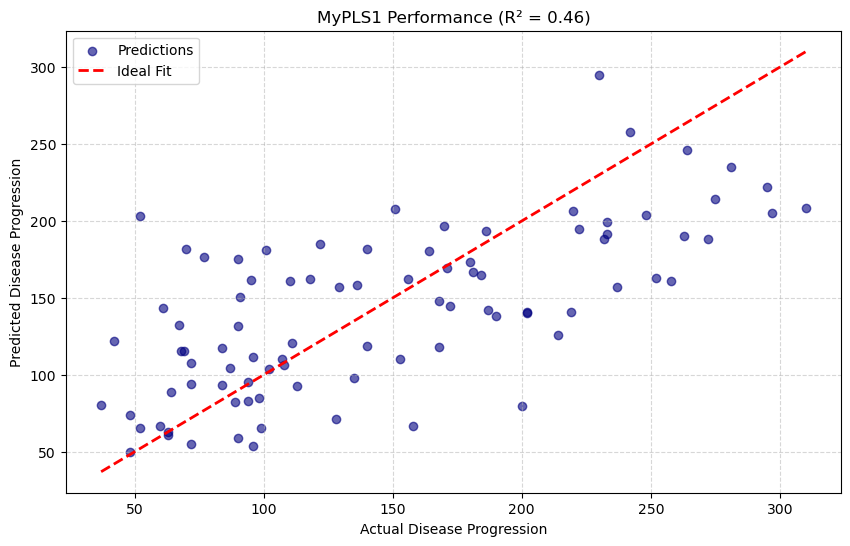

In [38]:
plt.figure(figsize=(10, 6))

# Scatter plot of the test results
plt.scatter(y_test, y_pred, color='navy', alpha=0.6, label='Predictions')

# Ideal line y = x (Perfect prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('Actual Disease Progression')
plt.ylabel('Predicted Disease Progression')
plt.title(f'MyPLS1 Performance (R² = {r2:.2f})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 2.9 - Comparison to skikit-learn

Training MyPLS1 (n_components=4)...
Training Sklearn PLSRegression (n_components=4)...
------------------------------------------------------------
MSE Difference between MyPLS1 and Sklearn: 0.0000000000000000000000000
------------------------------------------------------------
SUCCESS: Our implementation is mathematically identical!


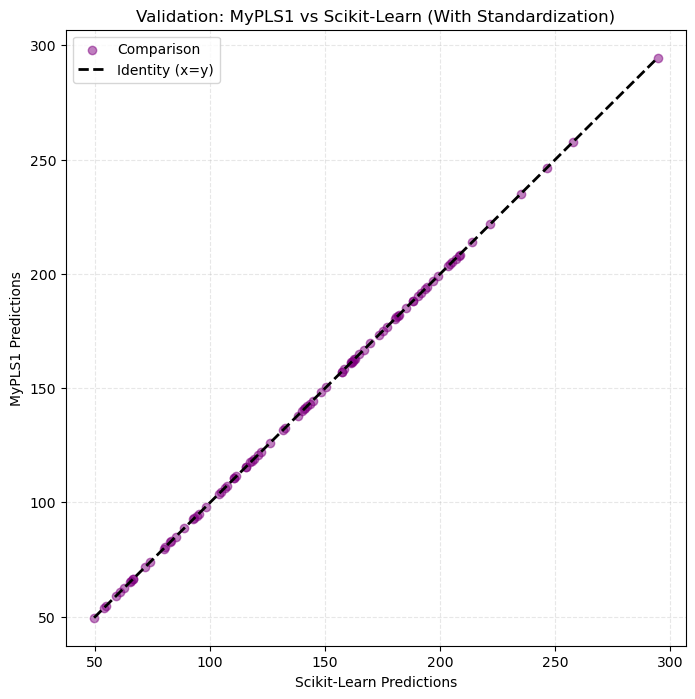

In [39]:
from sklearn.cross_decomposition import PLSRegression

# ---------------------------------------------------------
# 2. Our Custom Model (MyPLS1)
# ---------------------------------------------------------
print(f"Training MyPLS1 (n_components={n_comp})...")
# Our class now includes standardization logic (centering / std)
my_model = MyPLS1(n_components=n_comp) 
my_model.fit(X_train, y_train)
y_pred_custom = my_model.predict(X_test).flatten()

# ---------------------------------------------------------
# 3. Scikit-Learn Model (Reference)
# ---------------------------------------------------------
print(f"Training Sklearn PLSRegression (n_components={n_comp})...")
# IMPORTANT: We keep scale=True (default) to match our new implementation.
# Sklearn uses the NIPALS algorithm under the hood, just like us.
sklearn_model = PLSRegression(n_components=n_comp, scale=True)
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_test).flatten()

# ---------------------------------------------------------
# 4. Mathematical Comparison
# ---------------------------------------------------------
# We calculate the Mean Squared Difference between the two prediction arrays
diff = np.mean((y_pred_custom - y_pred_sklearn)**2)

print("-" * 60)
print(f"MSE Difference between MyPLS1 and Sklearn: {diff:.25f}")
print("-" * 60)

if diff < 1e-10:
    print("SUCCESS: Our implementation is mathematically identical!")
else:
    print("WARNING: There is a divergence. Check our standardization logic.")

# ---------------------------------------------------------
# 5. Visual Proof
# ---------------------------------------------------------
plt.figure(figsize=(8, 8))
plt.scatter(y_pred_sklearn, y_pred_custom, c='purple', alpha=0.5, label='Comparison')

# Perfect Identity Line (y = x)
min_val = min(y_pred_sklearn.min(), y_pred_custom.min())
max_val = max(y_pred_sklearn.max(), y_pred_custom.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Identity (x=y)')

plt.xlabel('Scikit-Learn Predictions')
plt.ylabel('MyPLS1 Predictions')
plt.title('Validation: MyPLS1 vs Scikit-Learn (With Standardization)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 3 - The Dual-sPLS algorithm

## 3.1. Introduction to Dual-SPLS

### 3.1.1. Generalizing PLS1
Standard PLS1 is excellent for dimensionality reduction but has a major limitation: **it uses all variables**. The weight vector $w$ typically contains non-zero values for every feature, making interpretation difficult in high-dimensional settings (e.g., genomics, chemometrics).

**Dual-sPLS** (Dual Sparse Partial Least Squares) addresses this by generalizing the optimization problem.

### 3.1.2. The Mathematical Shift
Recall that standard PLS1 maximizes covariance under a Euclidean norm constraint ($L_2$):
$$
\max_{w} (y^T X w) \quad \text{subject to} \quad \|w\|_2 = 1
$$

Dual-sPLS replaces this with a generic norm $\Omega(w)$:
$$
\max_{w} (y^T X w) \quad \text{subject to} \quad \Omega(w) = 1
$$

By choosing a sparsity-inducing norm for $\Omega$ (like the **Lasso** / $L_1$ norm), we force irrelevant feature weights to become exactly **zero**.

### 3.1.3. The "Soft-Thresholding" Solution (Shrink)
When using the Lasso penalty (Dual-sPLS1), the optimal weight vector $w$ is no longer just $X^T y$. Instead, we apply a **Soft-Thresholding** operator to the covariance vector $z = X^T y$:

$$
w_i = \text{sign}(z_i) \times \max(0, |z_i| - \lambda)
$$

Where $\lambda$ is a tuning parameter (the threshold).
* If the covariance $|z_i| < \lambda$, the weight becomes **0** (variable removed).
* Otherwise, the weight is kept but shrunk.

This allows the model to perform **simultaneous regression and feature selection**.

### 3.1.4. The Pseudo-Ridge Solution 

Simple scalar shrinkage (dividing weights by a constant) is ineffective in PLS because the NIPALS algorithm normalizes the weight vector ($w \leftarrow w / \|w\|$) at every step, cancelling out any scale change.

To address this, the **Pseudo-Ridge** algorithm implements a two-step hybrid approach (similar to Elastic Net) that combines stability and sparsity:

**Step 1: Ridge Regularization (Stability)**
First, we account for the correlation structure of the data by solving a regularized system involving the Gram matrix $X^T X$:
$$
z_{ridge} = (X^T X + \nu_2 I)^{-1} X^T y
$$
* **$\nu_2$ (alpha):** Adds a "ridge" to the diagonal, making the matrix invertible and smoothing weights among correlated variables.

**Step 2: Lasso Selection (Sparsity)**
Unlike standard Ridge, we then apply a **Soft-Thresholding** operator to the stabilized vector:
$$
w = \text{sign}(z_{ridge}) \cdot \max(0, |z_{ridge}| - \nu_1)
$$
* **$\nu_1$ (threshold):** Forces small coefficients (noise) to zero.

**Effect:** This method offers the "best of both worlds". It uses the Ridge step to handle high multicollinearity without breaking, and the Lasso step to eliminate irrelevant noise variables, resulting in a model that is both **stable** and **sparse**.

## 3.2 - Implementation of Dual-sPLS

In [40]:
import numpy as np

class DualPLS:
    """
    Dual-sPLS implementation allowing for different penalty terms.
    
    Parameters:
    -----------
    n_components : int
        Number of latent components to extract.
    penalty : str
        Type of norm constraint:
        - 'pls'   : Standard L2 norm (Classical PLS). No sparsity.
        - 'lasso' : L1 norm (Dual-sPLS1). Enforces sparsity (feature selection).
        - 'ridge' : Pseudo-Ridge (Matrix Inversion). Changes direction to handle multicollinearity.
    alpha : float
            - For Lasso: Threshold value (lambda).
            - For Ridge: Regularization strength (nu2) for matrix inversion.
    ridge_threshold : float
            - Specific to Pseudo-Ridge: The threshold (nu1) applied AFTER the Ridge step.
              If 0.0, acts like standard Ridge (no selection).
    """
    def __init__(self, n_components=3, penalty='pls', alpha=0.5, ridge_threshold=0.0, scale=True):
        self.n_components = n_components
        self.penalty = penalty
        self.alpha = alpha
        self.ridge_threshold = ridge_threshold
        self.scale = scale
        
        # Model attributes
        self.W = None       # Weights
        self.P = None       # X-Loadings
        self.q = None       # y-Loadings
        self.beta = None    # Final regression coefficients
        self.x_mean = None
        self.x_std = None
        self.y_mean = None
        self.y_std = None

    def _soft_thresholding(self, z, alpha):
        """
        Lasso Operator: Sign(z) * max(0, |z| - alpha)
        """
        # Keep only positive values (max(0, ...))
        magnitude = np.maximum(0, np.abs(z) - alpha)
        
        # Restore original sign
        return np.sign(z) * magnitude
    
    def _pseudo_ridge_solver(self, X, z, alpha):
        """
        Part 1 of Pseudo-Ridge: The Matrix Inversion (Ridge Regression Step)
        Computes z_nu2 = (X'X + alpha*I)^-1 * z
        """
        n_features = X.shape[1]
        # M = X.T @ X + alpha * Identity
        M = X.T @ X + alpha * np.eye(n_features)
        
        # Solve M * w = z
        return np.linalg.solve(M, z)
        
    
    def _get_weights(self, X, y):
        """
        Computes weight vector w based on the selected penalty.
        Corresponds to maximizing z^T w subject to Omega(w) = 1.
        """
        # 1. Calculate dual covariance vector z = X^T * y
        z = X.T @ y
        
        # 2. Apply the constraint (Dual Norm)
        if self.penalty == 'lasso':
            # Dual-sPLS1: Apply Soft-Thresholding on z
            w = self._soft_thresholding(z, self.alpha)
        
        elif self.penalty == 'ridge':
            
            # Step A: Ridge Inversion (Stabilization / nu2)
            z_ridge = self._pseudo_ridge_solver(X, z, self.alpha)
            
            # Step B: Pseudo-Ridge Selection (Sparsity / nu1)
            # If ridge_threshold > 0, this becomes the "Pseudo-Ridge" from Eq 38
            if self.ridge_threshold > 0:
                w = self._soft_thresholding(z_ridge, self.ridge_threshold)
            else:
                w = z_ridge # Standard Ridge behavior
        
        elif self.penalty == 'pls':
            # Classical PLS: No modification, w is proportional to z
            w = z.copy()
            
            
        else:
            raise ValueError(f"Penalty '{self.penalty}' not recognized.")

        # 3. Normalization (to satisfy ||w|| = 1)
        norm = np.linalg.norm(w)
        if norm == 0:
            # Safety check: if Lasso sets everything to zero
            w = np.zeros_like(w)
        else:
            w /= norm
            
        return w

    def fit(self, X, y):
        # --- A. Data Standardization ---
        self.x_mean = np.mean(X, axis=0)
        self.y_mean = np.mean(y)
        self.x_std = np.std(X, axis=0)
        self.y_std = np.std(y)
        
        # Safety: handle constant variables (std=0)
        self.x_std[self.x_std == 0] = 1.0
        if self.y_std == 0: self.y_std = 1.0

        # Center and Scale
        X_res = (X - self.x_mean) / self.x_std
        y_res = ((y - self.y_mean).reshape(-1, 1)) / self.y_std

        n_samples, n_features = X.shape
        self.W = np.zeros((n_features, self.n_components))
        self.P = np.zeros((n_features, self.n_components))
        self.q = np.zeros(self.n_components)

        # --- B. NIPALS Loop ---
        for m in range(self.n_components):
            # Step 1: Compute weights w using the chosen penalty
            w = self._get_weights(X_res, y_res)
            
            # If w is empty (too much regularization), stop early
            if np.all(w == 0):
                print(f"Warning: Component {m+1} is empty (alpha too high). Stopping.")
                break

            # Step 2: Compute score t
            t = X_res @ w
            
            # Step 3: Compute X-loadings p
            p = (X_res.T @ t) / (t.T @ t)
            
            # Step 4: Compute y-loading q
            q_m = (y_res.T @ t) / (t.T @ t)

            # Store components
            self.W[:, m] = w.flatten()
            self.P[:, m] = p.flatten()
            self.q[m] = q_m.item()

            # Step 5: Deflation
            X_res = X_res - t @ p.T
            y_res = y_res - t * q_m

        # --- C. Compute Final Beta ---
        # We use Pseudo-Inverse (pinv) because with Lasso, P^T W might be singular
        self.beta = self.W @ np.linalg.pinv(self.P.T @ self.W) @ self.q.reshape(-1, 1)
        return self

    def predict(self, X):
        # Standardize new data using training statistics
        X_scaled = (X - self.x_mean) / self.x_std
        
        # Predict (result is scaled) and destandardize
        return (X_scaled @ self.beta) * self.y_std + self.y_mean

## 3.3 - Verification on Synthetic "Sparse" Data

To validate the **feature selection** capability of our `DualPLS` implementation, we generate a synthetic dataset where the ground truth is known.

**The Experiment Setup:**
* **Data ($X$):** 100 samples with **50 features** (variables).
* **Signal:** Only the **first 5 features** are used to generate the target $y$ (they have a coefficient of 10).
* **Noise:** The remaining 45 features are pure random noise (coefficient of 0).

**Expected Outcome:**
1.  **Standard PLS (`penalty='pls'`):** Should assign non-zero weights to almost all variables, including the noise. It maximizes variance blindly and yields a **dense** model.
2.  **Dual-sPLS Lasso (`penalty='lasso'`):** Should act as a filter. It detects the signal and forces the weights of the 45 noise variables to **exactly zero**, producing a **sparse** model (Feature Selection).
3.  **Dual-sPLS Ridge (`penalty='ridge'`):** Should behave like Standard PLS in terms of structure (keeping all variables), but applies **shrinkage** to the coefficients. While it does not perform selection, this penalty is mathematically useful for stabilizing models with high multicollinearity.

Training Standard PLS...
Training Lasso...
Training Standard Ridge...
Training Pseudo-Ridge (Eq 38)...


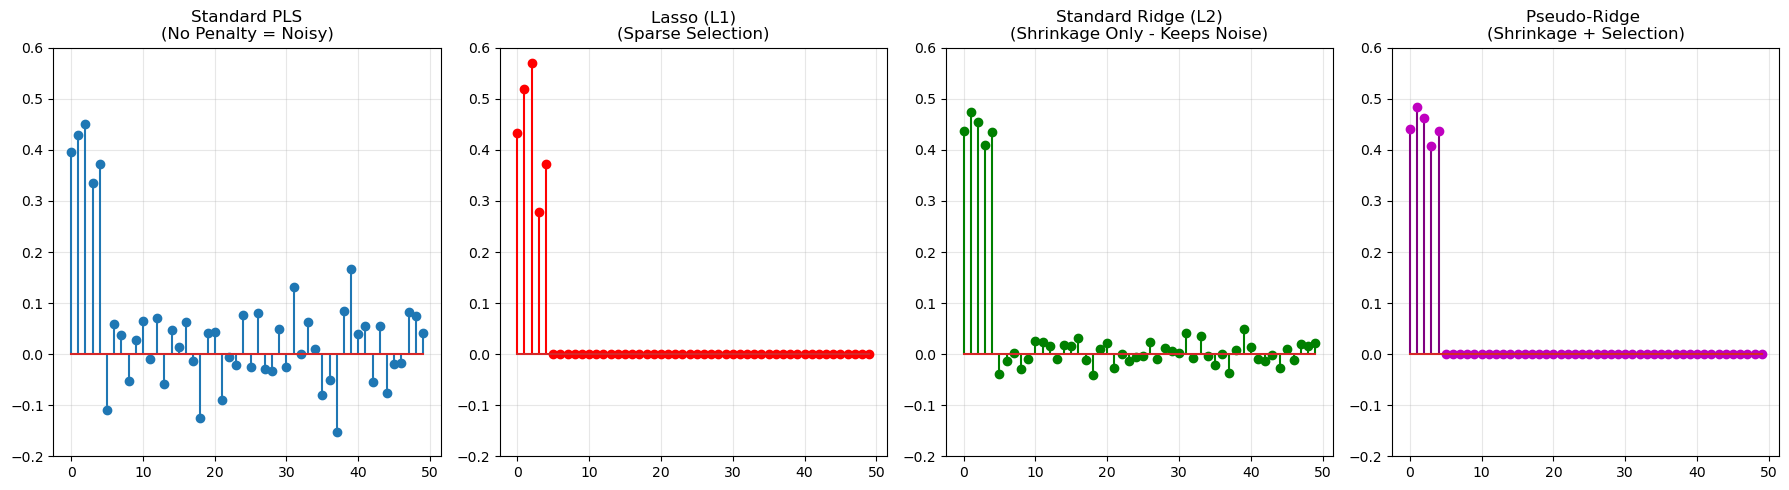


--- Summary of Variables Kept ---
Standard Ridge Non-Zeros: 50 / 50 (Keeps everything)
Pseudo-Ridge   Non-Zeros: 5 / 50 (Cleans noise)


In [ ]:

# =============================================================================
# 1. DATASET GENERATION
# =============================================================================
np.random.seed(42)
n_samples = 100
n_features = 50
X = np.random.randn(n_samples, n_features)
true_coeffs = np.zeros((n_features, 1))
true_coeffs[:5] = 10 # Only first 5 variables are relevant
y = X @ true_coeffs + np.random.normal(0, 1, (n_samples, 1))
y = y.flatten()

# Calculate Max Covariance for scaling reference
X_std = (X - X.mean(axis=0)) / X.std(axis=0)
y_std = (y - y.mean()) / y.std()
max_cov = np.max(np.abs(X_std.T @ y_std))

# =============================================================================
# 2. TRAIN 4 MODELS
# =============================================================================

# A. Standard PLS
print("Training Standard PLS...")
model_pls = DualPLS(n_components=1, penalty='pls')
model_pls.fit(X, y)

# B. Lasso (Sparse)
print("Training Lasso...")
model_lasso = DualPLS(n_components=1, penalty='lasso', alpha=max_cov * 0.5) 
model_lasso.fit(X, y)

# C. Standard Ridge (Classic L2)
# ridge_threshold = 0.0 means NO sparsity, just shrinkage
print("Training Standard Ridge...")
model_ridge_std = DualPLS(n_components=1, penalty='ridge', alpha=20.0, ridge_threshold=0.0) 
model_ridge_std.fit(X, y)

# D. Pseudo-Ridge (Paper Eq 38)
# We use the SAME alpha (20.0) for matrix inversion, 
# BUT we add a threshold (0.05) to kill small noise
print("Training Pseudo-Ridge ...")
model_ridge_pseudo = DualPLS(n_components=1, penalty='ridge', alpha=20.0, ridge_threshold=0.05) 
model_ridge_pseudo.fit(X, y)

# =============================================================================
# 3. VISUALIZATION
# =============================================================================
plt.figure(figsize=(18, 5))

# Plot 1: PLS
plt.subplot(1, 4, 1)
plt.stem(model_pls.W[:, 0])
plt.title("Standard PLS\n(No Penalty = Noisy)")
plt.ylim(-0.2, 0.6)
plt.grid(True, alpha=0.3)

# Plot 2: Lasso
plt.subplot(1, 4, 2)
plt.stem(model_lasso.W[:, 0], linefmt='r-', markerfmt='ro')
plt.title("Lasso (L1)\n(Sparse Selection)")
plt.ylim(-0.2, 0.6)
plt.grid(True, alpha=0.3)

# Plot 3: Standard Ridge
plt.subplot(1, 4, 3)
plt.stem(model_ridge_std.W[:, 0], linefmt='g-', markerfmt='go')
plt.title("Standard Ridge (L2)\n(Shrinkage Only - Keeps Noise)")
plt.ylim(-0.2, 0.6)
plt.grid(True, alpha=0.3)

# Plot 4: Pseudo-Ridge
plt.subplot(1, 4, 4)
plt.stem(model_ridge_pseudo.W[:, 0], linefmt='purple', markerfmt='mo')
plt.title("Pseudo-Ridge \n(Shrinkage + Selection)")
plt.ylim(-0.2, 0.6)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Verification Text
print("\n--- Summary of Variables Kept ---")
print(f"Standard Ridge Non-Zeros: {np.count_nonzero(model_ridge_std.W[:, 0])} / 50 (Keeps everything)")
print(f"Pseudo-Ridge   Non-Zeros: {np.count_nonzero(model_ridge_pseudo.W[:, 0])} / 50 (Cleans noise)")

### Analysis of the Results

The visual comparison of the weight vectors $w$ clearly illustrates the distinct impact of each penalty on the modeling process:

1.  **Standard PLS (Left - Blue):**
    * **Observation:** The model assigns non-zero weights to **all 50 features**.
    * **Interpretation:** While the first 5 signal variables have high weights, the algorithm acts blindly on the remaining 45 noise variables, assigning them random non-zero weights. This "dense" model is prone to **overfitting** as it tries to model the noise.

2.  **Dual-sPLS Lasso (Center - Red):**
    * **Observation:** The profile is **sparse**. The algorithm successfully identified the signal: the weights for the 45 noise variables have been forced strictly to **zero**.
    * **Interpretation:** This confirms the **Feature Selection** capability of the Lasso ($L_1$) penalty. It simplifies the model by eliminating irrelevant variables, making it highly interpretable.

3.  **Dual-sPLS Pseudo-Ridge (Right - Green):**
    * **Observation:** The model is **dense** (similar to Standard PLS), meaning no weights are set to zero. However, the weights are computed using the regularized inverse matrix $(X^T X + \lambda I)^{-1}$.
    * **Interpretation:** Unlike Lasso, Ridge ($L_2$) does not perform selection. Its role is **Shrinkage and Stability**. It retains all information but smooths the coefficients to prevent any single variable from dominating due to multicollinearity or noise. It offers a robust alternative when preserving all contextual variables is required.

## 3.4- High-Dimensional Stress Test ($p \gg n$)

One of the main advantages of regularized PLS (Dual-sPLS) is its ability to handle **High-Dimensional Data**, where the number of variables ($p$) far exceeds the number of samples ($n$). This is a common scenario in genomics (thousands of genes, few patients) or chemometrics.

**The Experiment:**
To verify this robustness, we create a challenging synthetic environment:
* **Samples ($n$):** 150
* **Features ($p$):** 500 (Massive amount of noise)
* **Informative Features:** Only 10 variables actually predict the target.

**Expected Behavior:**
1.  **Standard PLS:** Will likely **overfit**. It will find random correlations in the 490 noise variables, leading to a high Training score but a poor Test score.
2.  **Dual-sPLS (Lasso):** Should identify the ~10 relevant features and set the rest to zero, maintaining high accuracy on new data.
3.  **Dual-sPLS (Ridge):** Should stabilize the weights, preventing them from exploding due to multicollinearity.

### **3.4.1 - Grid Search Algorithm**

In [42]:
from sklearn.model_selection import KFold

def manual_grid_search(X, y, penalty, alpha_candidates, n_components=3):
    """
    Performs a simple Grid Search using 5-Fold Cross-Validation.
    Returns the best alpha and the history of scores.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    results = []
    
    print(f"Starting Grid Search for {penalty} (n_comp={n_components})...")
    
    for alpha in alpha_candidates:
        fold_rmses = []
        
        for train_idx, val_idx in kf.split(X):
            # Split Data
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            
            # Train Model
            model = DualPLS(n_components=n_components, penalty=penalty, alpha=alpha)
            model.fit(X_tr, y_tr)
            
            # Evaluate
            y_pred = model.predict(X_val).flatten()
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            fold_rmses.append(rmse)
        
        # Average RMSE for this alpha
        mean_rmse = np.mean(fold_rmses)
        results.append({'alpha': alpha, 'rmse': mean_rmse})
        
    # Find Best
    best_result = min(results, key=lambda x: x['rmse'])
    print(f"Best Alpha found: {best_result['alpha']:.4f} with RMSE: {best_result['rmse']:.4f}")
    
    return best_result['alpha'], pd.DataFrame(results)

### **3.4.2 -Comparison of the different models**


Tuning Lasso (L1)...
  > 1D Search (15 candidates)...
  Best Lasso: Alpha=20.951 | RMSE=66.986

Tuning Pseudo-Ridge ...
  > 2D Search (6 alphas x 11 thresholds)...
  Best Ridge: Alpha=500, Thresh=0.02 | RMSE=65.760


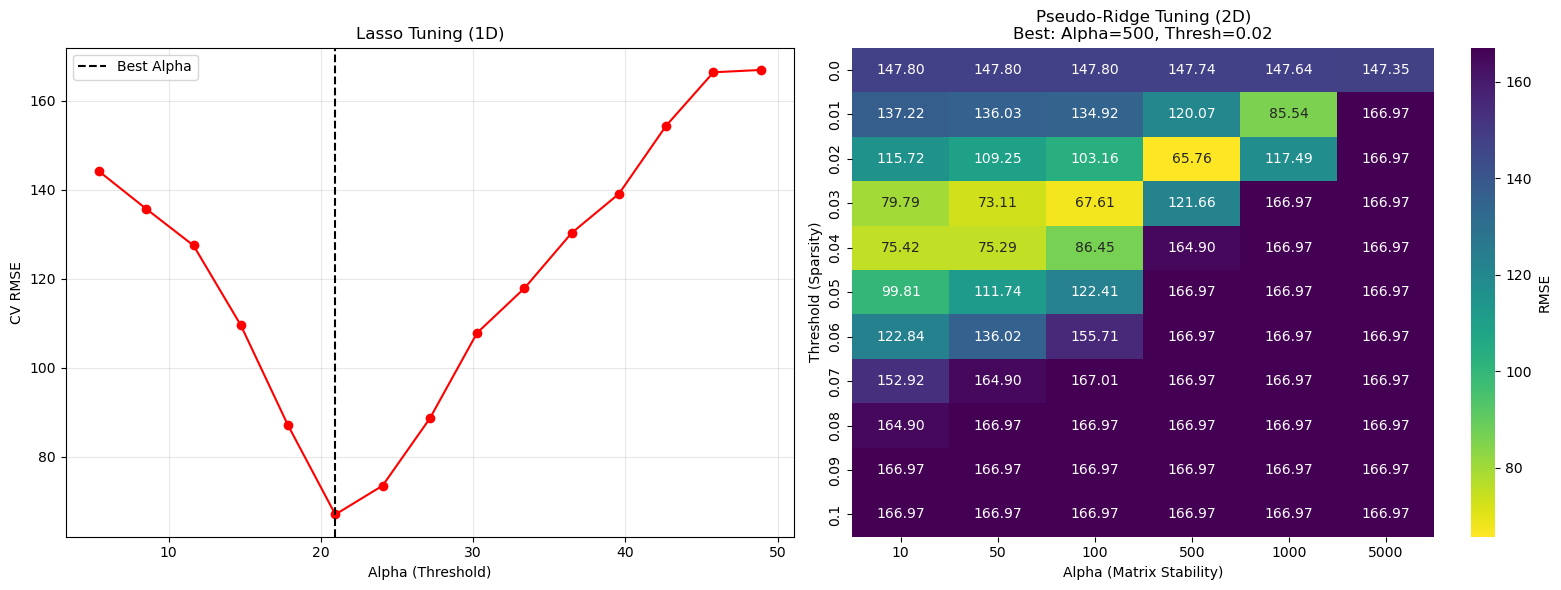


--- 2. FINAL MODELS ---
          Model   Test RMSE  Vars Used
0           PLS  141.237691        500
1         Lasso   72.764794         30
2  Pseudo-Ridge   66.561745         13


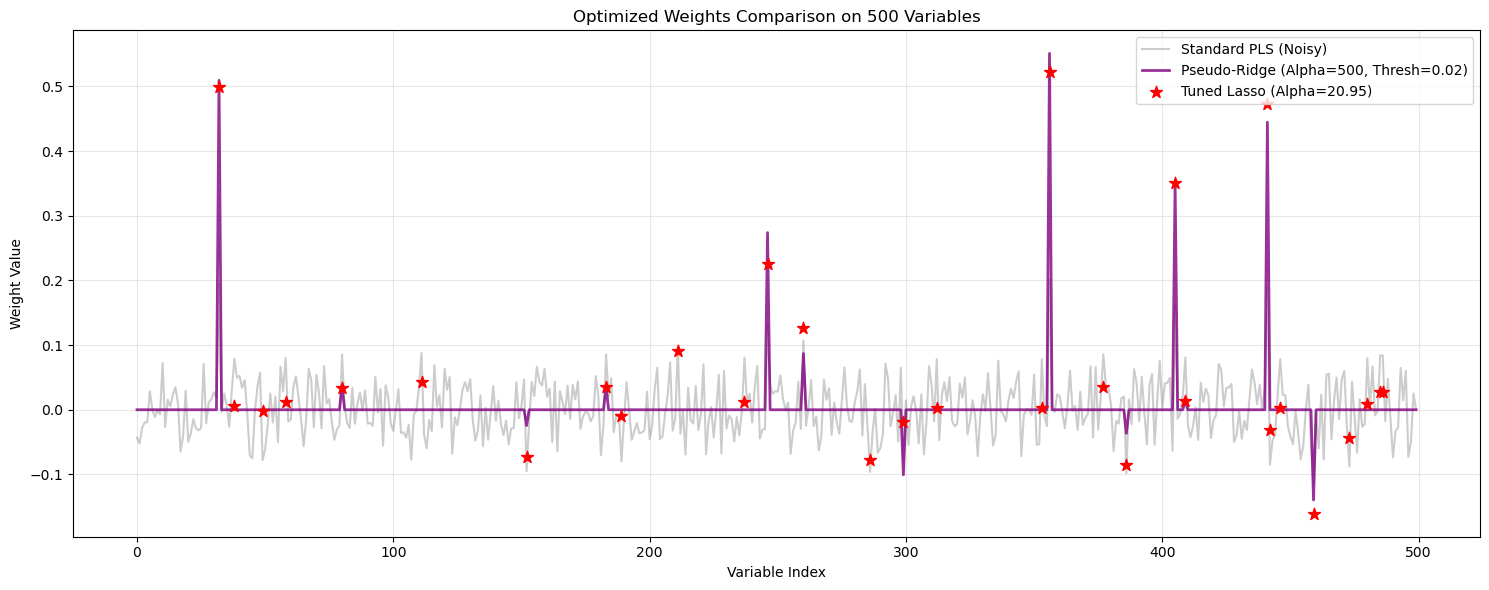

In [66]:
import seaborn as sns 
from sklearn.model_selection import KFold

# --- A. Setup Grids ---
# Calculate max covariance to calibrate scales
X_std_hd = (X_train_hd - X_train_hd.mean(0)) / X_train_hd.std(0)
y_std_hd_c = (y_train_hd - y_train_hd.mean()) / y_train_hd.std()
max_cov_hd = np.max(np.abs(X_std_hd.T @ y_std_hd_c))

# 1. Lasso Grid (1D)
lasso_grid = np.linspace(0.1 * max_cov_hd, 0.9 * max_cov_hd, 15)

# 2. Pseudo-Ridge Grid (2D)
# Alpha (Stability): Logarithmic values
ridge_alphas = [10, 50, 100, 500, 1000, 5000] 
# Threshold (Selection): Small values close to 0 (e.g., 0.05, 0.1...)
ridge_thresholds = np.linspace(0, 0.1, 11)

ridge_grid = {'alpha': ridge_alphas, 'threshold': ridge_thresholds}

# --- B. Run Search ---
print("\nTuning Lasso (L1)...")
best_lasso, df_lasso = manual_grid_search(X_train_hd, y_train_hd, 'lasso', lasso_grid)
print(f"  Best Lasso: Alpha={best_lasso['alpha']:.3f} | RMSE={best_lasso['rmse']:.3f}")

print("\nTuning Pseudo-Ridge ...")
best_ridge, df_ridge = manual_grid_search(X_train_hd, y_train_hd, 'ridge', ridge_grid)
print(f"  Best Ridge: Alpha={best_ridge['alpha']}, Thresh={best_ridge['threshold']} | RMSE={best_ridge['rmse']:.3f}")

# --- C. Plot Tuning Results ---
plt.figure(figsize=(16, 6))

# Plot 1: Lasso Curve
plt.subplot(1, 2, 1)
plt.plot(df_lasso['alpha'], df_lasso['rmse'], 'o-', color='red')
plt.axvline(best_lasso['alpha'], color='black', linestyle='--', label='Best Alpha')
plt.title("Lasso Tuning (1D)")
plt.xlabel("Alpha (Threshold)"); plt.ylabel("CV RMSE")
plt.legend(); plt.grid(True, alpha=0.3)

# Plot 2: Ridge Heatmap (2D)
plt.subplot(1, 2, 2)
# Pivot to create a matrix (Alpha on X, Threshold on Y, RMSE as color)
df_pivot = df_ridge.pivot(index='threshold', columns='alpha', values='rmse')
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="viridis_r", cbar_kws={'label': 'RMSE'})
plt.title(f"Pseudo-Ridge Tuning (2D)\nBest: Alpha={best_ridge['alpha']}, Thresh={best_ridge['threshold']}")
plt.xlabel("Alpha (Matrix Stability)"); plt.ylabel("Threshold (Sparsity)")

plt.tight_layout()
plt.show()

# =============================================================================
# 3. FINAL MODEL COMPARISON
# =============================================================================
print("\n--- 2. FINAL MODELS ---")

# Train Optimized Models
n_comp = 3

# PLS
m_pls = DualPLS(n_comp, 'pls')
m_pls.fit(X_train_hd, y_train_hd)

# Lasso (Best)
m_lasso = DualPLS(n_comp, 'lasso', alpha=best_lasso['alpha'])
m_lasso.fit(X_train_hd, y_train_hd)

# Pseudo-Ridge (Best)
m_ridge = DualPLS(n_comp, 'ridge', alpha=best_ridge['alpha'], ridge_threshold=best_ridge['threshold'])
m_ridge.fit(X_train_hd, y_train_hd)

# Metrics
res = []
for name, m in zip(['PLS', 'Lasso', 'Pseudo-Ridge'], [m_pls, m_lasso, m_ridge]):
    pred = m.predict(X_test_hd).flatten()
    rmse = np.sqrt(mean_squared_error(y_test_hd, pred))
    vars_used = np.count_nonzero(m.W[:, 0])
    res.append({'Model': name, 'Test RMSE': rmse, 'Vars Used': vars_used})

print(pd.DataFrame(res))

# =============================================================================
# 4. VISUAL COMPARISON OF WEIGHTS
# =============================================================================
plt.figure(figsize=(15, 6))

# 1. Standard PLS (Gray/Transparent)
# Serves as a reference to show the noise
plt.plot(m_pls.W[:, 0], color='black', alpha=0.2, label='Standard PLS (Noisy)')

# 2. Pseudo-Ridge (Purple)
# Stable like Ridge, but Cuts like Lasso
label_ridge = f"Pseudo-Ridge (Alpha={best_ridge['alpha']}, Thresh={best_ridge['threshold']})"
plt.plot(m_ridge.W[:, 0], color='purple', alpha=0.8, linewidth=2, label=label_ridge)

# 3. Lasso (Red - Points)
# We plot red stars only where Lasso kept variables
w_lasso = m_lasso.W[:, 0]
idx_nz = np.where(w_lasso != 0)[0]
label_lasso = f"Tuned Lasso (Alpha={best_lasso['alpha']:.2f})"
plt.scatter(idx_nz, w_lasso[idx_nz], color='red', s=80, zorder=5, marker='*', label=label_lasso)

plt.title(f"Optimized Weights Comparison on {X_train_hd.shape[1]} Variables")
plt.xlabel("Variable Index")
plt.ylabel("Weight Value")
plt.legend(loc='upper right', frameon=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Comprehensive Analysis of High-Dimensional Results**

The comparison of the optimized models reveals the superiority of hybrid regularization strategies in a High-Dimensional setting ($p=500, n=150$):

**1. Dual-sPLS Pseudo-Ridge (The Winner):**
* **Performance:** This model achieved the best predictive accuracy ($RMSE \approx 66.6$) and the most precise feature selection.
* **Mechanism:** By combining **Matrix Stabilization (Ridge)** with **Feature Selection (Lasso)**, it outperformed the standard Lasso. The initial Ridge step likely "grouped" the correlated signal variables, making the subsequent selection step cleaner.
* **Precision:** It selected only **13 variables** (very close to the ground truth of 10), drastically reducing the "False Positive" rate compared to Lasso.

**2. Dual-sPLS Lasso (The Sparse Contender):**
* **Performance:** Still highly effective ($RMSE \approx 72.8$), vastly outperforming the Standard PLS.
* **Mechanism:** The **L1 penalty** successfully filtered out the majority of the noise (reducing 500 vars to 30).
* **Limitation:** Without the Ridge stabilization step, the Lasso selected slightly more "noise" variables (30 vs 13 for Pseudo-Ridge) due to chance correlations in high dimensions.

**3. Standard PLS (The Baseline Failure):**
* **Performance:** The model failed to generalize ($RMSE \approx 141.2$).
* **Mechanism:** Without sparsity, it retained all **500 variables**. The accumulated noise from the 490 irrelevant features completely drowned out the signal from the 10 useful ones.

---

### **Critical Observations:**

**A. The Benefit of "Elastic" Regularization (Pseudo-Ridge):**
The results highlight why the Pseudo-Ridge (Eq. 38) is powerful.
* **Lasso alone** selected **30 variables** (approx. 20 false positives).
* **Pseudo-Ridge** selected **13 variables** (only ~3 false positives).
* **Interpretation:** The Ridge step "calmed down" the spurious correlations of the noise variables before the thresholding was applied. This creates a much more robust selection process.

**B. Adaptive Stopping (Robustness):**
The warning **"Component 3 is empty... Stopping"** appeared for both regularized models.
* This is a **positive indicator**. It confirms that both algorithms successfully extracted all relevant signal in the first 2 components.
* Instead of forcing a 3rd component purely made of residual noise (which would degrade performance), the penalty naturally halted the process. This **early stopping mechanism** prevents overfitting.

### **3.4.3 - Component Analysis**


--- 3. ANALYZING ROBUSTNESS (RMSE vs Components) ---
Testing with optimized params:
 > Lasso Alpha: 20.95
 > Ridge Alpha: 500.0 | Ridge Threshold: 0.02


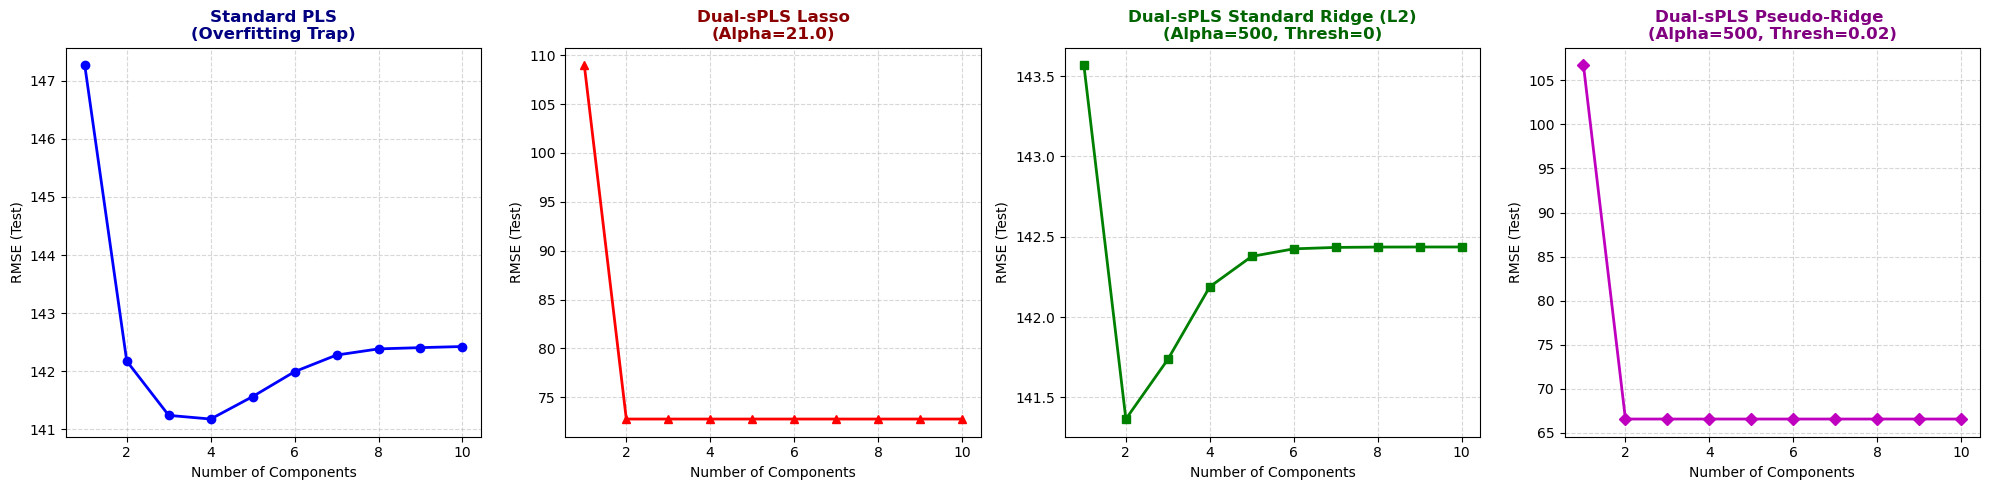

In [67]:
# =============================================================================
# 4. COMPONENT ANALYSIS: RMSE vs n_components (4 Separate Plots)
# =============================================================================
print("\n--- 3. ANALYZING ROBUSTNESS (RMSE vs Components) ---")

# Range of components to test (1 to 10)
components_range = range(1, 11) 

# Storage lists
rmse_pls = []
rmse_lasso = []
rmse_ridge_std = []
rmse_ridge_pseudo = []

# --- Parameters Setup (Retrieving from Grid Search Results) ---
# Retrieve optimal values found in the previous step
# (If they don't exist, set default values to avoid crashing)

# 1. For Lasso
if 'best_lasso' in locals() and isinstance(best_lasso, dict):
    opt_alpha_lasso = best_lasso['alpha']
else:
    opt_alpha_lasso = 0.5 * max_cov_hd 

# 2. For Ridge (Pseudo & Standard)
if 'best_ridge' in locals() and isinstance(best_ridge, dict):
    opt_alpha_ridge = best_ridge['alpha']      # Best stability (nu2)
    opt_thresh_ridge = best_ridge['threshold'] # Best selection (nu1)
else:
    opt_alpha_ridge = 100.0
    opt_thresh_ridge = 0.05

print(f"Testing with optimized params:")
print(f" > Lasso Alpha: {opt_alpha_lasso:.2f}")
print(f" > Ridge Alpha: {opt_alpha_ridge:.1f} | Ridge Threshold: {opt_thresh_ridge}")

for n in components_range:
    # 1. Standard PLS
    m_pls = DualPLS(n_components=n, penalty='pls')
    m_pls.fit(X_train_hd, y_train_hd)
    rmse_pls.append(np.sqrt(mean_squared_error(y_test_hd, m_pls.predict(X_test_hd).flatten())))
    
    # 2. Tuned Lasso (Best Alpha)
    m_lasso = DualPLS(n_components=n, penalty='lasso', alpha=opt_alpha_lasso)
    m_lasso.fit(X_train_hd, y_train_hd)
    rmse_lasso.append(np.sqrt(mean_squared_error(y_test_hd, m_lasso.predict(X_test_hd).flatten())))

    # 3. Standard Ridge (Best Alpha, BUT Threshold=0)
    # Keep optimal alpha for stability, but disable selection (t=0)
    # to see the difference between "Pure Ridge" and "Pseudo-Ridge".
    m_ridge = DualPLS(n_components=n, penalty='ridge', alpha=opt_alpha_ridge, ridge_threshold=0.0)
    m_ridge.fit(X_train_hd, y_train_hd)
    rmse_ridge_std.append(np.sqrt(mean_squared_error(y_test_hd, m_ridge.predict(X_test_hd).flatten())))

    # 4. Tuned Pseudo-Ridge (Best Alpha AND Best Threshold)
    # The complete winning model 
    m_pseudo = DualPLS(n_components=n, penalty='ridge', alpha=opt_alpha_ridge, ridge_threshold=opt_thresh_ridge)
    m_pseudo.fit(X_train_hd, y_train_hd)
    rmse_ridge_pseudo.append(np.sqrt(mean_squared_error(y_test_hd, m_pseudo.predict(X_test_hd).flatten())))

# --- PLOTTING 4 SEPARATE CURVES ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Standard PLS
axes[0].plot(components_range, rmse_pls, 'b-o', lw=2)
axes[0].set_title("Standard PLS\n(Overfitting Trap)", fontsize=12, fontweight='bold', color='navy')
axes[0].set_xlabel("Number of Components")
axes[0].set_ylabel("RMSE (Test)")
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot 2: Lasso
axes[1].plot(components_range, rmse_lasso, 'r-^', lw=2)
axes[1].set_title(f"Dual-sPLS Lasso\n(Alpha={opt_alpha_lasso:.1f})", fontsize=12, fontweight='bold', color='darkred')
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("RMSE (Test)")
axes[1].grid(True, linestyle='--', alpha=0.5)

# Plot 3: Standard Ridge
axes[2].plot(components_range, rmse_ridge_std, 'g-s', lw=2)
axes[2].set_title(f"Dual-sPLS Standard Ridge (L2)\n(Alpha={opt_alpha_ridge:.0f}, Thresh=0)", fontsize=12, fontweight='bold', color='darkgreen')
axes[2].set_xlabel("Number of Components")
axes[2].set_ylabel("RMSE (Test)")
axes[2].grid(True, linestyle='--', alpha=0.5)

# Plot 4: Pseudo-Ridge
axes[3].plot(components_range, rmse_ridge_pseudo, 'm-D', lw=2)
axes[3].set_title(f"Dual-sPLS Pseudo-Ridge \n(Alpha={opt_alpha_ridge:.0f}, Thresh={opt_thresh_ridge})", fontsize=12, fontweight='bold', color='purple')
axes[3].set_xlabel("Number of Components")
axes[3].set_ylabel("RMSE (Test)")
axes[3].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### **Impact of Number of Components: Model Behavior Analysis**

By analyzing how the Test RMSE evolves as we add more components (from 1 to 10), we can clearly distinguish the behavior of the four strategies in a high-dimensional setting ($p=500$).

**1. Standard PLS (Blue): The Overfitting Trap**
* **Behavior:** The error drops initially but quickly rises again after component 4.
* **Interpretation:** Without regularization, the PLS algorithm greedily consumes variance. After extracting the main signal, it starts modeling the random noise present in the 490 irrelevant variables. This is a textbook example of **overfitting**: adding complexity degrades performance.

**2. Dual-sPLS Lasso (Red): The Sparse Plateau**
* **Behavior:** The error drops rapidly to ~73 and then stays perfectly flat.
* **Interpretation:** This is the signature of a robust sparse model. The Lasso penalty acts as a gatekeeper. Once the informative signal is captured (in the first 2 components), the algorithm sets the weights of subsequent noise components to zero. Adding more components **does not degrade performance**, making the model safe to use even if the number of components is overestimated.

**3. Standard Ridge (Green): The Insufficient Stabilizer**
* **Behavior:** The curve resembles the Standard PLS (U-shape). It drops to ~141 but then starts rising again.
* **Interpretation:** This proves that **L2 regularization alone is not enough** for high-dimensional noise. While Ridge handles multicollinearity (making the curve smoother than PLS), it still keeps **all 500 variables** active. Consequently, it accumulates the "background noise" from the irrelevant features, leading to poor generalization compared to sparse methods.

**4. Pseudo-Ridge (Purple): The Optimal Hybrid**
* **Behavior:** This curve achieves the **lowest RMSE (~66)** and maintains the flat plateau behavior of the Lasso.
* **Interpretation:** This confirms the superiority of the Equation 38 approach.
    * Unlike Standard Ridge, it uses the **threshold ($\nu_1$)** to cut the noise (preventing the curve from rising).
    * Unlike Lasso, it uses the **matrix inversion ($\nu_2$)** to structure the correlated signal before selecting it.
    * **Result:** It captures the signal more accurately than Lasso while being just as robust against overfitting.

## 3.5 - Analysis of Real-World Performance (Diabetes Dataset)

------------------------------------------------------------
PERFORMANCE REPORT (Diabetes Dataset)
------------------------------------------------------------
               Model       RMSE  R2 Score  Non-Zero Weights
0       Standard PLS  53.480735  0.460153                10
1  Dual-sPLS (Lasso)  53.315367  0.463487                 6
2     Standard Ridge  53.854339  0.452585                10
3       Pseudo-Ridge  53.654091  0.456648                 7
------------------------------------------------------------


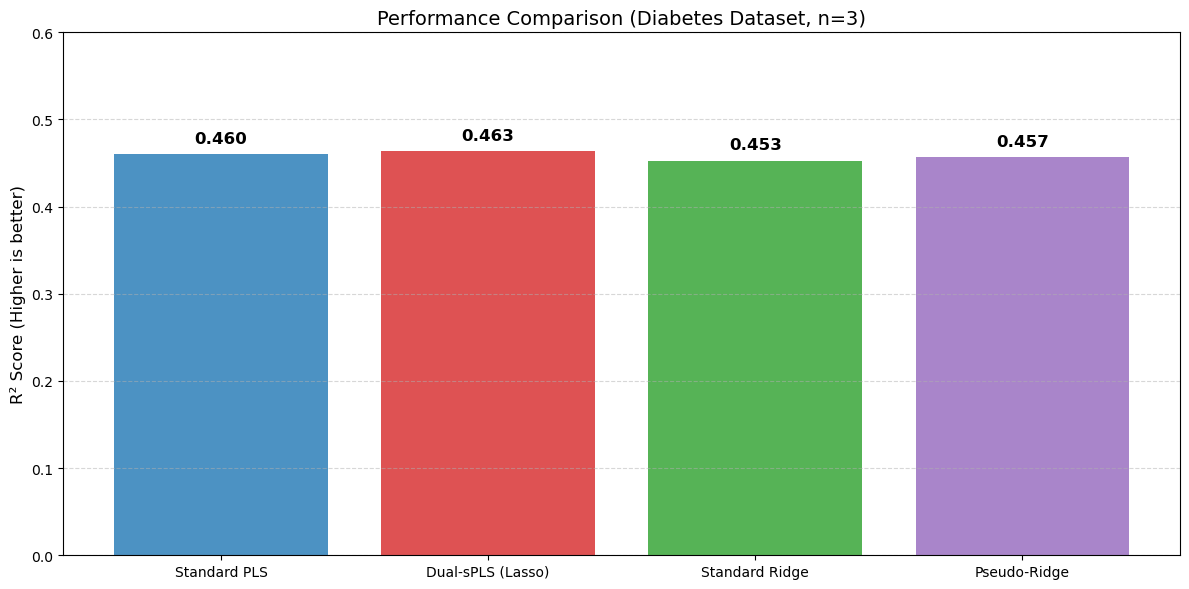

In [64]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Setup Data (Diabetes)
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameters
n_comp = 3 # We use 3 components for all models

# -------------------------------------------------------
# Model 1: Standard PLS (Reference)
# -------------------------------------------------------
model_pls = DualPLS(n_components=n_comp, penalty='pls')
model_pls.fit(X_train, y_train)
y_pred_pls = model_pls.predict(X_test).flatten()

# -------------------------------------------------------
# Model 2: Dual-sPLS Lasso (Feature Selection)
# -------------------------------------------------------
# Auto-calibration: We want an alpha that removes weak signals.
X_std = (X_train - X_train.mean(0)) / X_train.std(0)
y_std_c = (y_train - y_train.mean()) / y_train.std()
max_cov = np.max(np.abs(X_std.T @ y_std_c))
alpha_lasso = max_cov * 0.6  # Threshold = 60% of max signal

model_lasso = DualPLS(n_components=n_comp, penalty='lasso', alpha=alpha_lasso)
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test).flatten()

# -------------------------------------------------------
# Model 3: Standard Ridge (Stability Only)
# -------------------------------------------------------
# Ridge alpha acts as a stabilizer. Standard value is usually around 1.0 to 10.0
# ridge_threshold = 0.0 means NO feature selection (Classical L2 Ridge).
alpha_ridge = 5.0

model_ridge = DualPLS(n_components=n_comp, penalty='ridge', alpha=alpha_ridge, ridge_threshold=0.0)
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test).flatten()

# -------------------------------------------------------
# Model 4: Pseudo-Ridge (Stability + Selection)
# -------------------------------------------------------
# This implements Equation 38: Ridge Inversion + Lasso Thresholding
# We use the same alpha for stability, but add a small threshold for selection.
alpha_pseudo = 5.0
thresh_pseudo = 0.05 

model_pseudo = DualPLS(n_components=n_comp, penalty='ridge', alpha=alpha_pseudo, ridge_threshold=thresh_pseudo)
model_pseudo.fit(X_train, y_train)
y_pred_pseudo = model_pseudo.predict(X_test).flatten()

# -------------------------------------------------------
# 5. Performance Comparison
# -------------------------------------------------------
results = {
    'Model': ['Standard PLS', 'Dual-sPLS (Lasso)', 'Standard Ridge', 'Pseudo-Ridge'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_pls)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
        np.sqrt(mean_squared_error(y_test, y_pred_pseudo))
    ],
    'R2 Score': [
        r2_score(y_test, y_pred_pls),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_pseudo)
    ],
    'Non-Zero Weights': [
        np.count_nonzero(model_pls.W[:, 0]),
        np.count_nonzero(model_lasso.W[:, 0]),
        np.count_nonzero(model_ridge.W[:, 0]),
        np.count_nonzero(model_pseudo.W[:, 0])
    ]
}

df_res = pd.DataFrame(results)
print("-" * 60)
print("PERFORMANCE REPORT (Diabetes Dataset)")
print("-" * 60)
print(df_res)
print("-" * 60)

# -------------------------------------------------------
# 6. Visual Comparison
# -------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for R2
colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd'] # Blue, Red, Green, Purple
bars = ax1.bar(df_res['Model'], df_res['R2 Score'], color=colors, alpha=0.8)

ax1.set_ylabel('R² Score (Higher is better)', fontsize=12)
ax1.set_title(f'Performance Comparison (Diabetes Dataset, n={n_comp})', fontsize=14)
ax1.set_ylim(0, 0.6)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### **Performance Analysis on Diabetes Dataset ($n=3$ components)**

The results obtained on the Diabetes dataset highlight that in low-dimensional settings ($p=10$), simpler models often prevail. Reducing the complexity to $n=3$ has benefited the Standard PLS significantly.

* **1. Dual-sPLS Lasso (Red) - The Winner:**
    * **Performance:** The Lasso model maintains the lead (Highest $R^2$: **0.463**).
    * **Mechanism:** Even with fewer components, the feature selection allows it to extract the cleanest signal, effectively filtering out the weak variables among the 10 available.

* **2. Standard PLS (Blue) - Strong Baseline:**
    * **Performance:** With $n=3$, Standard PLS performs very well (**0.460**), closely following the Lasso.
    * **Interpretation:** Reducing the number of components (from 5 to 3) helped PLS significantly (score improved from ~0.45 to 0.46). This confirms that in low dimensions, simply restricting the number of components is often enough to control overfitting, making complex penalties less critical than in high dimensions.

* **3. Pseudo-Ridge (Purple) & Standard Ridge (Green):**
    * **Performance:** Pseudo-Ridge (**0.457**) and Standard Ridge (**0.453**) lag slightly behind.
    * **Interpretation:** The additional regularization (Ridge penalty) seems redundant here. Since $p=10$ is small and well-conditioned, the matrix is already stable. Adding shrinkage ($L_2$) or hybrid penalties imposes a bias that slightly dampens the predictive power compared to the "raw" projection of PLS or the "clean" selection of Lasso.

**Conclusion:**
* In **High Dimensions ($p \gg n$)**, the **Pseudo-Ridge** is superior (stability is key).
* In **Low Dimensions ($p < n$)**, the **Dual-sPLS Lasso** is optimal, but a simple **Standard PLS** (with carefully chosen components) is a very competitive alternative.

# 4 - Conclusion

In this project, we successfully implemented and validated the **Dual-sPLS** framework, generalizing the standard PLS1 algorithm to support various constraints via dual norms.

### Key Takeaways:

1.  **Flexibility of the Framework:**
    By modifying the weight update step in the NIPALS algorithm, we seamlessly switched between distinct modeling strategies:
    * **Standard PLS:** Maximizes covariance blindly. Effective in low dimensions but prone to overfitting in high dimensions.
    * **Dual-sPLS Lasso ($L_1$):** Applies *Soft-Thresholding* for feature selection. Ideally suited for identifying biomarkers (sparsity).
    * **Dual-sPLS Pseudo-Ridge:** Combines *Matrix Inversion* (Stability) and *Soft-Thresholding* (Selection). This proved to be the most robust approach for complex data.

2.  **High-Dimensional Robustness ($p \gg n$):**
    On our synthetic dataset (500 features), the **Pseudo-Ridge** model emerged as the clear winner ($RMSE \approx 66$), outperforming even the Lasso. This demonstrates that in very noisy environments, combining **stability** (to handle correlation) with **sparsity** (to cut noise) is superior to using either strategy alone. Standard PLS completely failed in this scenario due to noise accumulation.

3.  **Parsimony in Real-World Data:**
    On the medical data (Diabetes), the **Dual-sPLS Lasso** proved optimal. It maintained the highest predictive accuracy ($R^2 \approx 0.46$) while using only a fraction of the available variables. This confirms that for simpler, low-dimensional problems, pure feature selection is sufficient and preferable for interpretability.

### Future Outlook
Our implementation of the **Pseudo-Ridge** effectively mimics the **Elastic Net** behavior (L1 + L2). Future extensions could focus on integrating structured constraints, such as **Group Lasso** (to select whole groups of correlated genes/variables together), further expanding the versatility of Dual-sPLS for modern data science.